In [1]:
from kalman_gst import *  
from pygsti.modelpacks import smq1Q_XYI as std

In [2]:
SAMPLES = 256

# Experiment 1: fast and exact filters on a particular noise model

In [3]:
# setup the FOGI model
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
target_model = mdl_datagen.copy()

In [4]:
mdl_datagen.fogi_errorgen_component_labels()

('H(X:0)_[]',
 'H(Y:0)_[]',
 'H(Z:0)_[]',
 'S(X:0)_[]',
 'S(Y:0)_[]',
 'S(Z:0)_[]',
 'H(X:0)_Gxpi2:0',
 'S(X:0)_Gxpi2:0',
 '(0.5 S(Y:0) + 0.5 S(Z:0))_Gxpi2:0',
 'H(Y:0)_Gypi2:0',
 '(0.5 S(X:0) + 0.5 S(Z:0))_Gypi2:0',
 'S(Y:0)_Gypi2:0',
 'ga(-H(Z:0))_Gypi2:0 - ga(-H(Z:0))_Gxpi2:0',
 'ga(H(Y:0))_rho0 - ga(H(Y:0))_Gxpi2:0',
 'ga(-H(Y:0))_Mdefault - ga(-H(Y:0))_Gxpi2:0',
 'ga(H(X:0))_rho0 - ga(H(X:0))_Gypi2:0',
 'ga(-H(X:0))_Mdefault - ga(-H(X:0))_Gypi2:0',
 'ga(-0.5 S(X:0) - 0.5 S(Y:0))_Mdefault - ga(-0.5 S(X:0) - 0.5 S(Y:0))_rho0')

In [5]:
hamiltonian_params = [0, 1, 2, 6, 9]
print([mdl_datagen.fogi_errorgen_component_labels()[i] for i in hamiltonian_params])

['H(X:0)_[]', 'H(Y:0)_[]', 'H(Z:0)_[]', 'H(X:0)_Gxpi2:0', 'H(Y:0)_Gypi2:0']


In [6]:
# add noise to the stochastic and hamiltonian parts of the FOGI rates
SEED = 3122
np.random.seed(SEED)

max_stochastic_error_rate = 0.001
hamiltonian_error_var = 0.05
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)


# add hamiltonian noise
ar[0:3] = np.random.normal(0, hamiltonian_error_var, 3)
ar[9] = np.random.normal(0, hamiltonian_error_var)
ar[6] = np.random.normal(0, hamiltonian_error_var)
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)
print('hamiltonian-only MSE with target', mserror(mdl_datagen, target_model))
print('hamiltonian-only agsi with target', avg_gs_infidelity(mdl_datagen, target_model))

# add stochastic noise
ar[3:6] = max_stochastic_error_rate*np.random.rand(3)
ar[7:9] = max_stochastic_error_rate*np.random.rand(2)
ar[10:12] = max_stochastic_error_rate*np.random.rand(2)
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

print('MSE with target', mserror(mdl_datagen, target_model))
print('agi with target', avg_gs_infidelity(mdl_datagen, target_model))

hamiltonian-only MSE with target 0.013944923672360084
hamiltonian-only agsi with target 0.0027790049441692053
MSE with target 0.01394719147439365
agi with target 0.0034387883628380854


In [7]:
print(avg_gs_infidelity(mdl_datagen, target_model)*target_model.num_params)

0.061898190531085535


In [8]:
print('model is cptp', model_is_cptp(mdl_datagen))

model is cptp True


In [9]:
"""run a direct RB experiment"""
from pygsti.processors import CliffordCompilationRules as CCR
compilations = {'absolute': CCR.create_standard(std.processor_spec(), 'absolute', ('paulis', '1Qcliffords'), verbosity=0),            
                'paulieq': CCR.create_standard(std.processor_spec(), 'paulieq', ('1Qcliffords', 'allcnots'), verbosity=0)}
depths = [0,1,2,4,8,16,32,64]
k = 10
# To run direct / mirror RB change CliffordRBDesign -> DirectRBDesign / MirrorRBDesign
rb_edesign = pygsti.protocols.CliffordRBDesign(std.processor_spec(), compilations, depths, k)
rb_dataset = pygsti.data.simulate_data(mdl_datagen, rb_edesign, 1000)
rb_data = pygsti.protocols.ProtocolData(rb_edesign, rb_dataset)
rb_protocol = pygsti.protocols.RB()
rb_results = rb_protocol.run(rb_data)
rb_rate = rb_results.fits['full'].estimates['r']

- Sampling 10 circuits at CRB length 0 (1 of 8 depths) with seed 329483
- Sampling 10 circuits at CRB length 1 (2 of 8 depths) with seed 329493
- Sampling 10 circuits at CRB length 2 (3 of 8 depths) with seed 329503
- Sampling 10 circuits at CRB length 4 (4 of 8 depths) with seed 329513
- Sampling 10 circuits at CRB length 8 (5 of 8 depths) with seed 329523
- Sampling 10 circuits at CRB length 16 (6 of 8 depths) with seed 329533
- Sampling 10 circuits at CRB length 32 (7 of 8 depths) with seed 329543
- Sampling 10 circuits at CRB length 64 (8 of 8 depths) with seed 329553


/home/jpmarceaux/Applications/pyGSTi/pygsti/layouts/evaltree.py:183: UserWarning: Created an evaluation tree that is inefficient: tree-size > 10 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulator (e.g. MapForwardSimulator).
  _warnings.warn(("Created an evaluation tree that is inefficient: tree-size > %d * #circuits !\n"


In [10]:
"""make a GST edesign and simulate the data"""
maxLengths = [1,2,4,8,16]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [11]:
"""uncomment to recalculate model matrices"""
# jdict = {}
# hdict = {}
# for circ in tqdm(edesign.circuit_lists[-1]):
#     jdict[circ] = matrix_from_jacob(target_model.sim.dprobs(circ), 2**circ.width)
#     hdict[circ] = tensor_from_hessian(target_model.sim.hprobs(circ), 2**circ.width)
# pickle_dict(jdict, 'XYI_jacs')
# pickle_dict(hdict, 'XYI_hess')

'uncomment to recalculate model matrices'

In [12]:
"""load the model jacobians and hessians and calculate target model predictions"""
jdict = load_dict('XYI_jacs')
hdict = load_dict('XYI_hess')

In [13]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 3.0s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 6.0s


In [14]:
print('initial MLE model is cptp', model_is_cptp(mle_estimates[0]))
print('mse with datagen', mserror(mdl_datagen, mle_estimates[0]))
print('agsi with datagen', avg_gs_infidelity(mdl_datagen, mle_estimates[0]))

initial MLE model is cptp False
mse with datagen 0.0006090160207932837
agsi with datagen -0.0019240844645599165


In [15]:
print('final MLE model is cptp', model_is_cptp(mle_estimates[-1]))
print('mse with datagen', mserror(mdl_datagen, mle_estimates[-1]))
print('agsi with datagen', avg_gs_infidelity(mdl_datagen, mle_estimates[-1]))

final MLE model is cptp False
mse with datagen 2.079974205042119e-05
agsi with datagen -0.00014070555068861345


In [16]:
"""filter the dataset using an exact filter seeded at the target and mle1 estimate"""
prior_covar_strength =  (rb_rate)/target_model.num_params
prior_covar = prior_covar_strength*np.eye(target_model.num_params)

ekf1 = ExtendedKalmanFilter(target_model, prior_covar)
ekf2 = ExtendedKalmanFilter(mle_estimates[0], prior_covar)

ekf1.filter_dataset(edesign.circuit_lists[-1], dataset)
ekf2.filter_dataset(edesign.circuit_lists[-1], dataset)

100%|█████████████████████████████████████████| 616/616 [00:48<00:00, 12.64it/s]


In [17]:
"""filter the dataset using a fast filter seeded at the target"""
prior_covar_strength =  (rb_rate)/target_model.num_params
prior_covar = prior_covar_strength*np.eye(target_model.num_params)

fkf1 = ExtendedKalmanFilter(target_model, prior_covar)

fkf1.fast_filter_dataset(edesign.circuit_lists[-1], dataset, jdict, hdict)

100%|████████████████████████████████████████| 616/616 [00:04<00:00, 127.52it/s]


In [18]:
"""construct a reseeded fast filter"""
initial_circuit_index = 285
prior_model = target_model.copy()
prior_model.from_vector(ekf1.param_history[initial_circuit_index])

jacs_reseeded = dict()
hess_reseeded = dict()

for circ in tqdm(edesign.circuit_lists[-1][initial_circuit_index::]):
    jacs_reseeded[circ] = matrix_from_jacob(prior_model.sim.dprobs(circ), 2**circ.width)
    hess_reseeded[circ] = tensor_from_hessian(prior_model.sim.hprobs(circ), 2**circ.width)

100%|█████████████████████████████████████████| 331/331 [05:08<00:00,  1.07it/s]


In [19]:
"""estimate with the reseeded fast filter"""
fkf2 = ExtendedKalmanFilter(prior_model, ekf1.covar_history[initial_circuit_index])
fkf2.fast_filter_dataset(edesign.circuit_lists[-1][initial_circuit_index::], dataset, jacs_reseeded, hess_reseeded)

100%|████████████████████████████████████████| 331/331 [00:03<00:00, 102.91it/s]


In [20]:
"""set germ circuit ranges for the mle batches"""
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616],
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


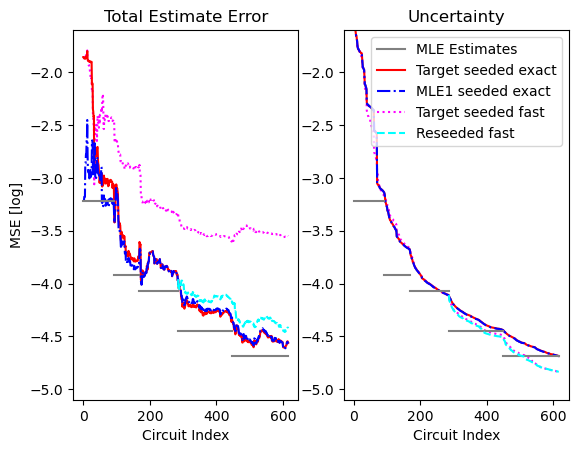

In [26]:
"""Evolution of MSE and uncertainty"""
fig, axs = plt.subplots(1, 2)
y_range = [-5.1, -1.6]

axs[0].set_title('Total Estimate Error')
axs[1].set_title('Uncertainty')

true_params = mdl_datagen.to_vector()
ekf1_error = []
ekf2_error = []
fkf1_error = []
fkf2_error = []

ekf1_uncert = []
ekf2_uncert = []
fkf1_uncert = []
fkf2_uncert = []

for i in range(len(ekf1.param_history)):
    ekf1_error.append( np.log10((ekf1.param_history[i]-true_params)@(ekf1.param_history[i]-true_params)) )
    ekf2_error.append( np.log10((ekf2.param_history[i]-true_params)@(ekf2.param_history[i]-true_params)) )
    fkf1_error.append( np.log10((fkf1.param_history[i]-true_params)@(fkf1.param_history[i]-true_params)) )
    ekf1_uncert.append( np.log10((np.trace(ekf1.covar_history[i]))) )
    ekf2_uncert.append( np.log10((np.trace(ekf2.covar_history[i]))) )
    fkf1_uncert.append( np.log10((np.trace(fkf1.covar_history[i]))) )

    
fkf1_uline, = axs[1].plot(fkf1_uncert, c='magenta', linestyle='dotted')
ekf1_uline, = axs[1].plot(ekf1_uncert, c='red', linestyle='solid')
ekf2_uline, = axs[1].plot(ekf2_uncert, c='blue', linestyle='dashdot')

fkf1_line, = axs[0].plot(fkf1_error, c='magenta', linestyle='dotted')
ekf1_line, = axs[0].plot(ekf1_error, c='red', linestyle='solid')
ekf2_line, = axs[0].plot(ekf2_error, c='blue', linestyle='dashdot')

if mle_estimates is not None:
    for i, mdl in enumerate(mle_estimates):
        mle_error = np.log10(mserror(mdl, mdl_datagen))
        mle_line, = axs[0].plot(germ_length_ranges[i], (mle_error, mle_error), c='gray', label='MLE Estimate')
        mle_line, = axs[1].plot(germ_length_ranges[i], (mle_error, mle_error), c='gray', label='MLE Estimate')

plot_reseeded = True
if plot_reseeded:
    for i in range(len(fkf2.param_history)):
        fkf2_error.append( np.log10((fkf2.param_history[i]-true_params)@(fkf2.param_history[i]-true_params)) )
        fkf2_uncert.append( np.log10((np.trace(fkf2.covar_history[i]))) )
    fkf2_uline, = axs[1].plot(range(initial_circuit_index, len(ekf1.param_history)), fkf2_uncert, c='cyan', linestyle='dashed')
    fkf2_line, = axs[0].plot(range(initial_circuit_index, len(ekf1.param_history)), fkf2_error, c='cyan', linestyle='dashed')
    axs[1].legend([mle_line, ekf1_line, ekf2_line, fkf1_line, fkf2_line], ['MLE Estimates', 'Target seeded exact', 'MLE1 seeded exact', 'Target seeded fast', 'Reseeded fast'])
else:
    axs[1].legend([mle_line, ekf1_line, ekf2_line, fkf1_line], ['MLE Estimates', 'Target seeded exact', 'MLE1 seeded exact', 'Target seeded fast'])


if y_range is not None:
    axs[0].set_ylim(y_range[0], y_range[1])
    axs[1].set_ylim(y_range[0], y_range[1])
axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('MSE [log]')
fig.savefig('Figures/MSE_evolution.eps', dpi=350, format="eps", pad_inches=0.1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [20]:
%matplotlib inline

'H(Y:0)_Gypi2:0'

In [45]:
hamiltonian_params

[0, 1, 2, 6, 9]

Text(0, 0.5, 'Estimate error')

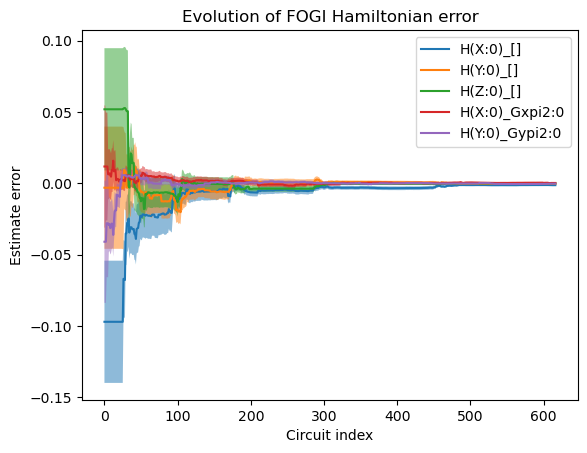

In [42]:
"""evolution of Hamiltonian parameter error"""

ekf1_mserrors = np.zeros((len(hamiltonian_params), len(ekf1.param_history)))
ekf1_var = np.zeros((len(hamiltonian_params), len(ekf1.param_history)))
true_params = mdl_datagen.to_vector()

for i in range(len(ekf1.param_history)):
    for j in range(len(hamiltonian_params)):
        ekf1_mserrors[j, i] = ekf1.param_history[i][hamiltonian_params[j]]-true_params[hamiltonian_params[j]]
        ekf1_var[j, i] = ekf1.covar_history[i][hamiltonian_params[j],hamiltonian_params[j]]
param_lines = []   
for j in range(len(hamiltonian_params)):
    line, = plt.plot(ekf1_mserrors[j, :])
    sigma = np.sqrt(ekf1_var[j, :])
    param_lines.append(line)
    plt.fill_between(range(len(ekf1_mserrors[j, :])), ekf1_mserrors[j, :]-sigma, ekf1_mserrors[j, :]+sigma, alpha=0.5)
plt.legend(param_lines, [mdl_datagen.fogi_errorgen_component_labels()[i] for i in hamiltonian_params])

plt.title('Evolution of FOGI Hamiltonian error')
plt.xlabel('Circuit index')
plt.ylabel('Estimate error')

In [48]:
print(mdl_datagen.fogi_errorgen_component_labels()[6], mdl_datagen.fogi_errorgen_component_labels()[9])

H(X:0)_Gxpi2:0 H(Y:0)_Gypi2:0


In [54]:
ekf1.covar_history[0].shape

(18, 18)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


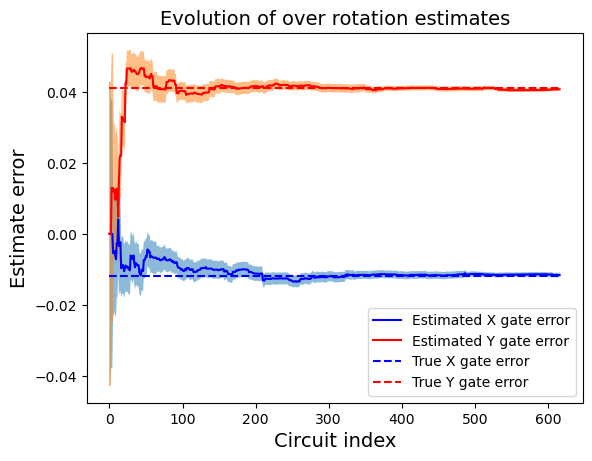

In [32]:
"""evolution of over-rotation error"""

overrot_errors = np.zeros((2, len(ekf1.param_history)))
true_params = mdl_datagen.to_vector()

for i in range(len(ekf1.param_history)):
    overrot_errors[0, i] = ekf1.param_history[i][6]
    overrot_errors[1, i] = ekf1.param_history[i][9]
    
xline_estimate, = plt.plot(overrot_errors[0, :], c='blue')
sigmas = np.sqrt([c[6,6] for c in ekf1.covar_history])
plt.fill_between(range(len(overrot_errors[0, :])), overrot_errors[0, :]-sigmas, overrot_errors[0, :]+sigmas, alpha=0.5)
yline_estimate, = plt.plot(overrot_errors[1, :], c='red')
sigmas = np.sqrt([c[9,9] for c in ekf1.covar_history])
plt.fill_between(range(len(overrot_errors[1, :])), overrot_errors[1, :]-sigmas, overrot_errors[1, :]+sigmas, alpha=0.5)

xline_true, = plt.plot((0, len(overrot_errors[0, :])), (true_params[6], true_params[6]), c='blue', linestyle='dashed')
yline_true, = plt.plot((0, len(overrot_errors[0, :])), (true_params[9], true_params[9]), c='red', linestyle='dashed')

    
plt.legend([xline_estimate, yline_estimate, xline_true, yline_true], ['Estimated X gate error', 'Estimated Y gate error', 'True X gate error', 'True Y gate error'], loc='lower right')

plt.title('Evolution of over rotation estimates', fontsize=14)
plt.xlabel('Circuit index', fontsize=14)
plt.ylabel('Estimate error', fontsize=14)
plt.savefig('Figures/Overrot.eps', dpi=350, format="eps", pad_inches=0.1)